# Obce z lokalit rovnou

Cena tepla podle paliva v obcích z předběžných dat [ERÚ](https://www.eru.cz/documents/10540/462926/Vysledne_ceny_tepla_2018.pdf) za rok 2020. Transformace z lokalit v řádcích na obce v řádcích. Není to bez chyb, ale pro orientační představu snad stačí.

In [1]:
import camelot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get pdf from the web and use Camelot to retrieve tables
pdf = 'http://www.eru.cz/documents/10540/462926/Predbezne_ceny_tepla_2020+%E2%80%93%20web.pdf'
tables = camelot.read_pdf(pdf, pages='1-end')
tables

<TableList n=50>

In [2]:
# Prepare header and labels
header = ['lokalita', 'kraj', 'pod_uhli', 'pod_plyn', 'pod_bio', 'pod_olej',\
          'pod_ost', 'vykon', 'nad_10_czk', 'nad_10_gj',\
          'pod_10_czk','pod_10_gj','cptv_czk', 'cptv_gj',\
          'prim_rozv_czk', 'prim_rozv_gj','cvs_czk', 'cvs_gj',\
          'cvs_voda_czk', 'cvs_voda_gj','blok_kot_czk', 'blok_kot_gj',\
          'sek_rozv_czk', 'sek_rozv_gj',\
          'dps_czk', 'dps_gj', 'dom_kot_czk', 'dom_kot_gj']
podily = ['pod_uhli', 'pod_plyn', 'pod_bio', 'pod_olej', 'pod_ost']
labels = ['uhlí', 'zemní plyn', 'biomasa', 'topný olej', 'ostatní']

# Merge all tables into one DataFrame
ceny = []
for i in range(tables.n):
    ceny.extend(tables[i].data[2:])
ceny = pd.DataFrame(ceny, columns=header)

# Clean strings (decimal, thousand), repair null and convert to numeric types
ceny.loc[:, 'pod_uhli':] = ceny.loc[:, 'pod_uhli':].apply(lambda x: x.str.replace(',', '.'))
ceny.loc[:, 'pod_uhli':] = ceny.loc[:, 'pod_uhli':].apply(lambda x: x.str.replace(' ', ''))
ceny.loc[:, 'pod_uhli':] = ceny.loc[:, 'pod_uhli':].apply(pd.to_numeric)
ceny = ceny.fillna(0)
#There is a null value 
# ceny['lokalita'] = ceny['lokalita'].apply(lambda x: x.replace('\0', 'ti'))

In [3]:
ceny.head()

,lokalita,kraj,pod_uhli,pod_plyn,pod_bio,pod_olej,pod_ost,vykon,nad_10_czk,nad_10_gj,...,cvs_voda_czk,cvs_voda_gj,blok_kot_czk,blok_kot_gj,sek_rozv_czk,sek_rozv_gj,dps_czk,dps_gj,dom_kot_czk,dom_kot_gj
0,Abertamy - Hornická 468,K,0.0,100.0,0.0,0.0,0.0,0.132,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,600.38,736.0
1,Adamov,B,0.0,100.0,0.0,0.0,0.0,9.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,547.25,27000.0,0.00,0.0
2,Adamov,B,0.0,100.0,0.0,0.0,0.0,2.203,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,Adamov - Opletalova 38 a 22,B,0.0,100.0,0.0,0.0,0.0,0.460,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,641.95,1400.0
4,Adamov - Petra Jilemnického 18 (K 72),B,0.0,100.0,0.0,0.0,0.0,0.090,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,333.99,549.0


In [4]:
# Agregate energy and price from various supply options
gj = ceny.filter(regex='_gj+', axis=1).columns
czk = ceny.filter(regex='_czk+', axis=1).columns
ceny['dod_cena'] = np.average(ceny[czk], weights=ceny[gj], axis=1)
ceny['dod_mnozstvi'] = np.sum(ceny[gj], axis=1)

ceny.dod_mnozstvi.sum() == ceny.filter(regex='_gj+', axis=1).sum().sum()

True

In [5]:
np.average(ceny.filter(regex='_czk+', axis=1), weights=ceny.filter(regex='_gj+', axis=1))

438.4192261912718

In [6]:
np.average(ceny['dod_cena'], weights=ceny['dod_mnozstvi'])

438.4192261912718

In [7]:
# Obce z lokalit
ceny['obec'] = ceny.lokalita.str.split('-', 1).str.get(0).str.strip()

ceny['obec'] = ceny['obec'].str.split('č.p.').str.get(0).str.rstrip()
ceny['obec'] = ceny['obec'].str.split('č. p.').str.get(0).str.rstrip()
ceny['obec'] = ceny['obec'].str.split('(').str.get(0).str.rstrip()

ceny['obec'] = ceny['obec'].replace('[0-9]*/*,*', '', regex=True).str.strip()
ceny['obec'] = ceny['obec'].str.rstrip('I.*V.*X.*I*V*X*').str.strip()
ceny.obec.value_counts().size

772

In [8]:
# Energie z paliv 
ceny['uhli'] = ceny['dod_mnozstvi'] * ceny['pod_uhli']/100
ceny['plyn'] = ceny['dod_mnozstvi'] * ceny['pod_plyn']/100
ceny['biomasa'] = ceny['dod_mnozstvi'] * ceny['pod_bio']/100
ceny['olej'] = ceny['dod_mnozstvi'] * ceny['pod_olej']/100
ceny['ostatni'] = ceny['dod_mnozstvi'] * ceny['pod_ost']/100

In [9]:
# Nový DataFrame co řádek to obec
grouped = ceny.groupby('obec')
obce = pd.DataFrame()

In [10]:
obce['obec'] = grouped['obec'].first()
obce['kraj'] = grouped['kraj'].first()
# obce['odberatelu'] = grouped['pocet_odberat'].sum()
# obce['mist'] = grouped['pocet_mist'].sum()
# obce['lokalit'] = grouped['pocet_odberat'].count()
obce['vykon'] = grouped['vykon'].sum()

In [11]:
obce['teplo_mnozstvi'] = grouped['dod_mnozstvi'].sum()
obce['teplo_cena'] = grouped.apply(lambda x: np.average(x['dod_cena'], weights=x['dod_mnozstvi']))

In [12]:
for palivo in ['uhli', 'plyn', 'biomasa', 'olej', 'ostatni']:
    obce[palivo] = grouped[palivo].sum()

for palivo in ['uhli', 'plyn', 'biomasa', 'olej', 'ostatni']:
    obce[f'pod_{palivo}'] = obce[f'{palivo}']/obce['teplo_mnozstvi']

obce = obce.reset_index(drop=True)
obce[:5]

,obec,kraj,vykon,teplo_mnozstvi,teplo_cena,uhli,plyn,biomasa,olej,ostatni,pod_uhli,pod_plyn,pod_biomasa,pod_olej,pod_ostatni
0,Abertamy,K,0.132,736.0,600.380000,0.0,736.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Adamov,B,11.753,51849.0,418.608643,0.0,51849.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Albrechtice v Jizerských Horách,L,0.064,60.0,1173.340000,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Andělská Hora,T,0.300,1300.0,505.000000,0.0,1300.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Arnoltice,M,0.180,1100.0,407.000000,1100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
# Shrnutí cen tepla podle paliva při 100% podílu paliva v obci
columns = ['palivo', 'podil', 'count', 'wmean', 'mean',\
           'std', 'min', '25%', '50%', '75%', 'max']
subset = []
summary_100 = pd.DataFrame(columns=columns)

for palivo in ['uhli', 'plyn', 'biomasa', 'olej', 'ostatni']:
    s = pd.Series({'palivo': f'{palivo}', 'podil': 1})
    podil_100 = obce[f'pod_{palivo}'] == 1.0
    s = s.append(obce[podil_100]['teplo_cena'].describe())
    s['wmean'] = np.average(obce[podil_100]['teplo_cena'], weights = obce[podil_100][f'{palivo}'])
    subset.append(obce[podil_100]['teplo_cena'])
    summary_100 = summary_100.append(s, ignore_index=True)

summary_100

,palivo,podil,count,wmean,mean,std,min,25%,50%,75%,max
0,uhli,1,45.0,326.538940,515.647159,174.097200,168.000000,407.000000,500.000000,641.000000,993.000000
1,plyn,1,398.0,513.973553,532.570919,118.926845,162.406768,455.753947,529.041397,603.995204,1502.903754
2,biomasa,1,107.0,200.710048,309.265044,178.468671,0.460000,176.000000,275.000000,428.500000,741.150000
3,olej,1,21.0,787.352228,880.767580,142.125423,488.000000,832.290000,858.006222,921.910000,1173.340000
4,ostatni,1,9.0,275.644843,604.701007,356.681704,21.090000,449.364416,708.000000,724.900000,1221.910154


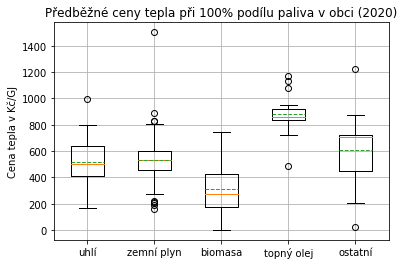

In [14]:
plt.boxplot(subset, labels=labels, showmeans=True, meanline=True)
plt.title('Předběžné ceny tepla při 100% podílu paliva v obci (2020)')
plt.ylabel('Cena tepla v Kč/GJ')
plt.grid()
plt.savefig('boxplot_cena_100_podil.svg', format='svg')
plt.savefig('boxplot_cena_100_podil.png', format='png', dpi=300)
plt.show()

In [15]:
obce.to_csv('obce_2020.csv', index=False)